## Import the needed package

In [1]:
# package to get the custom modules
import sys
# get the custom modules
sys.path.insert(0, './../../utilities')
# package for handling files
import os
# the custom modules
import utilities as util
# package for handling path
import paths
# package to handle random numbers
from random import randint

c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

## Global Variable

In [2]:
# paths where dataset is stored
path_test_ori = os.path.join(paths.path_split_origin, 'test')
path_test_aug = os.path.join(paths.path_split_augment, 'test')

## Get Dataset

In [3]:
# get the image and mask files
test_ori_img, test_ori_mask = util.load_img_mask(path_test_ori)
test_aug_img, test_aug_mask = util.load_img_mask(path_test_aug)
# create the tensorflow dataset
testset_ori = util.create_dataset(test_ori_img, test_ori_mask)
testset_aug = util.create_dataset(test_aug_img, test_aug_mask)

## Create Predicted Result

In [4]:
# model unet
pred_unet_mask_ori, _ = util.predict_model(testset_ori, paths.path_model, "unet_model_ori")
print("Unet model ori done")
pred_unet_mask_aug, _ = util.predict_model(testset_aug, paths.path_model, "unet_model_aug")
print("Unet model aug done")
# model mobilenet
pred_mnet_mask_ori, _ = util.predict_model(testset_ori, paths.path_model, "mnet_model_ori")
print("Mnet model ori done")
pred_mnet_mask_aug, _ = util.predict_model(testset_aug, paths.path_model, "mnet_model_aug")
print("Mnet model aug done")
# model efficientnet
pred_efnet_mask_ori, _ = util.predict_model(testset_ori, paths.path_model, "efnet_model_ori")
print("Efnet model ori done")
pred_efnet_mask_aug, _ = util.predict_model(testset_aug, paths.path_model, "efnet_model_aug")
print("Efnet model aug done")

del _

1/1 [==============================] - 26s 26s/step
Unet model ori done
1/1 [==============================] - 1s 588ms/step
Unet model aug done
1/1 [==============================] - 3s 3s/step
Mnet model ori done
1/1 [==============================] - 2s 2s/step
Mnet model aug done
1/1 [==============================] - 6s 6s/step
Efnet model ori done
1/1 [==============================] - 5s 5s/step
Efnet model aug done


## Split The Mask Image

In [5]:
# set the threshold value
threshold = .5

In [6]:
# show the predicted disc and cup area for the unet model in the original dataset
print("Unet model ori predicted mask")
unet_cup_mask_ori, unet_disc_mask_ori, unet_bcup_mask_ori, unet_bdisc_mask_ori = util.split_disc_cup_mask(pred_unet_mask_ori,
                                                                                                            threshold,
                                                                                                            visualize=False)
# show the predicted disc and cup area for the unet model in the augmented dataset
print("Unet model aug predicted mask")
unet_cup_mask_aug, unet_disc_mask_aug, unet_bcup_mask_aug, unet_bdisc_mask_aug = util.split_disc_cup_mask(pred_unet_mask_aug,
                                                                                                            threshold,
                                                                                                            visualize=False)

# show the predicted disc and cup area for the efficientnet model in the original dataset
print("Mnet model ori predicted mask")
mnet_cup_mask_ori, mnet_disc_mask_ori, mnet_bcup_mask_ori, mnet_bdisc_mask_ori = util.split_disc_cup_mask(pred_mnet_mask_ori,
                                                                                                            threshold,
                                                                                                            visualize=False)
# show the predicted disc and cup area for the efficientnet model in the augmented dataset
print("Mnet model aug predicted mask")
mnet_cup_mask_aug, mnet_disc_mask_aug, mnet_bcup_mask_aug, mnet_bdisc_mask_aug = util.split_disc_cup_mask(pred_mnet_mask_aug,
                                                                                                            threshold,
                                                                                                            visualize=False)

# show the predicted disc and cup area for the efficientnet model in the original dataset
print("Efnet model ori predicted mask")
efnet_cup_mask_ori, efnet_disc_mask_ori, efnet_bcup_mask_ori, efnet_bdisc_mask_ori = util.split_disc_cup_mask(pred_efnet_mask_ori,
                                                                                                                threshold,
                                                                                                                visualize=False)
# show the predicted disc and cup area for the efficientnet model in the augmented dataset
print("Efnet model aug predicted mask")
efnet_cup_mask_aug, efnet_disc_mask_aug, efnet_bcup_mask_aug, efnet_bdisc_mask_aug = util.split_disc_cup_mask(pred_efnet_mask_aug,
                                                                                                                threshold,
                                                                                                                visualize=False)

Unet model ori predicted mask
Unet model aug predicted mask
Mnet model ori predicted mask
Mnet model aug predicted mask
Efnet model ori predicted mask
Efnet model aug predicted mask


## Clasify The Eye Side

Still on experiment

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops

In [13]:
idx = randint(0, len(pred_unet_mask_ori)-1)

In [15]:
d_ymin, d_ymax, d_xmin, d_xmax, d_height, d_width = util.get_bounding_box(mnet_bdisc_mask_ori[idx])

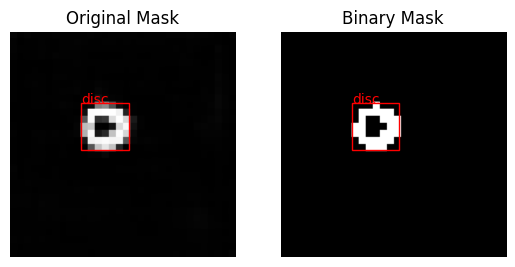

In [17]:
util.visualize_bounding_box("disc", mnet_disc_mask_ori[idx], mnet_bdisc_mask_ori[idx],
                            d_ymin, d_ymax, d_xmin, d_xmax)

In [ ]:
for images, labels in testset_ori.take(1):
    

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None))>